In [20]:
import collections


import tensorflow as tf
import h5py
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import kipoi

# Load Data

In [16]:
# tmp = h5py.File("/data/jwhughes/epitome/deepsea_train/train.mat")
train_data = {
    "x": np.load("deepsea_x.npy").transpose([2,1,0]),
    "y": np.load("deepsea_y.npy")
}

tmp = loadmat("/data/jwhughes/epitome/deepsea_train/valid.mat")
valid_data = {
    "x": tmp['validxdata'],
    "y": tmp['validdata'].T
}

tmp = loadmat("/data/jwhughes/epitome/deepsea_train/test.mat")
test_data = {
    "x": tmp['testxdata'],
    "y": tmp['testdata'].T
}

valid_data = {
    "x": np.concatenate([train_data["x"][2200000:2400000],train_data["x"][4200000:4400000],valid_data["x"]], axis=0),
    "y": np.concatenate([train_data["y"][:,2200000:2400000],train_data["y"][:,4200000:4400000],valid_data["y"]], axis=1),
}

train_data = {
    "x": np.concatenate([train_data["x"][0:2200000],train_data["x"][2400000:4200000]], axis=2),
    "y": np.concatenate([train_data["y"][:,0:2200000],train_data["y"][:,2400000:4200000]], axis=1),
} 

print(valid_data["x"].shape, train_data["x"].shape, test_data["x"].shape)
print(valid_data["y"].shape, train_data["y"].shape, test_data["y"].shape)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

# Choose cell types

['K562', 'GM12878', 'H1-hESC', 'HepG2', 'HeLa-S3', 'A549', 'HUVEC', 'GM12891', 'MCF-7', 'GM12892', 'HCT-116'] ['DNase', 'CTCF', 'Pol2', 'YY1', 'p300', 'TAF1', 'Pol2-4H8', 'c-Myc', 'Rad21', 'Max', 'NRSF', 'GABP', 'EZH2', 'CEBPB', 'c-Jun', 'ZBTB33', 'USF2', 'USF-1', 'TBP', 'RFX5']


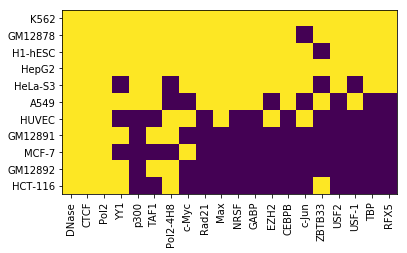

In [93]:
with open("/data/jwhughes/epitome/DeepSEA-v0.94/resources/feature_name") as f:
    i = 0
    assays = {}
    indexed_assays={}
    all_assays = set()
    for i,l in enumerate(f):
        if i == 0:
            continue
        cell, assay = l.split('\t')[1].split('|')[:2]
        if assay == 'DNase':
            assays[cell] = set([assay])
            indexed_assays[cell] = {assay: i-1}
        elif cell in assays:
            assays[cell].add(assay)
            indexed_assays[cell][assay] = i-1
            all_assays.add(assay)
all_assays.add('DNase')



cells = []

        
# best_assays
all_assays = []
for lst in assays.values():
    all_assays.extend(lst)
    
all_assays = collections.Counter(all_assays)
all_assays = [(all_assays[k], k) for k in all_assays]
sorted(all_assays, reverse=True)

all_cells = [(len(assays[cell]), cell) for cell in assays]
sorted(all_cells, reverse=True)

potential_assays = []
cells = []
best_assays = set(all_assays)

for a in assays:
    if len(assays[a]) > 5 and 'DNase' in assays[a] and a[:2]!="NH":
        potential_assays.extend(assays[a])
        best_assays = best_assays.intersection(assays[a])
        cells += [(len(assays[a]), a)]

# potential_assays = [i for i in potential_assays if i in assays['K562'] and i in (assays['GM12878'])]
cells = sorted(cells, reverse=True)
cells = [i[1] for i in cells]
potential_assays = collections.Counter(potential_assays)
potential_assays = sorted([(potential_assays[k], k) for k in potential_assays], reverse=True)
potential_assays = [i[1] for i in potential_assays]

cellmap = {cell: i for i, cell in enumerate(cells)}
assaymap = {assay: i for i, assay in enumerate(potential_assays)}
matrix = np.zeros((len(cellmap), len(assaymap))) - 1
for cell in cells:
    for assay in assays[cell].intersection(potential_assays):
        matrix[cellmap[cell], assaymap[assay]] = indexed_assays[cell][assay]

matrix = matrix.astype(int)[:11,:20]
        
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=-1)
print(list(cellmap.keys())[:11], list(assaymap.keys())[:20])

# Find the indices of the cell types and access them

In [44]:
# A549
valid_y_indices = matrix[5][matrix[5]!=-1]
# K562, HepG2
y_indices = [matrix[0][matrix[0]!=-1], matrix[3][matrix[3]!=-1]]

indices_mat = np.delete(matrix, [0,3,5], axis=0)

dnase_indices = indices_mat[:,0]
indices = indices_mat[indices_mat!=-1]


def gen(data, radii=[1,3]):
    def g():
        for i in range(max(radii), data["y"].shape[-1]-max(radii)):
            for y_index in y_indices:
                dnases = [0]
                for radius in radii:
                    dnase_double_positive = np.average(data["y"][dnase_indices,i-radius:i+radius+1]*
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    dnase_agreement = np.average(data["y"][dnase_indices,i-radius:i+radius+1]==
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    dnases.extend(dnase_double_positive)
                    dnases.extend(dnase_agreement)
                yield np.concatenate([data["y"][indices,i],dnases]), data["y"][y_index,i]
    return g

def make_dataset(data,
                 batch_size,
                 shuffle_size,
                 prefetch_size,
                 radii):
    
    generator = gen(data, radii)
    
    for x, y in generator():
        break
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32,)*2,
        output_shapes=(x.shape, y.shape,)
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(prefetch_size)
    return y.shape, dataset.make_one_shot_iterator()

# Check how DeepSea does

In [35]:
model = kipoi.get_model('DeepSEA/predict')
batch_size = 100
preds = []
for i in np.arange(0, len(valid_data["x"]), batch_size):
    batch = valid_data["x"][i:i+batch_size]
    batch = np.expand_dims(batch, 2)
    batch = batch[:,[0,2,1,3]]
    preds.append(model.predict_on_batch(batch.astype(np.float32)))
preds = np.concatenate(preds, axis=0)

(100, 919)

### Direct performance of DeepSea

In [60]:
# for i in range(20):
print(valid_data["y"][y_indices[0]].shape)
print(preds.T[y_indices[0]].shape)
sklearn.metrics.roc_auc_score(valid_data["y"][y_indices[0]].T, preds.T[y_indices[0]].T, average="macro")

(20, 408000)
(20, 408000)


0.9526236523215674

### Performance of DeepSea through averaging

In [71]:
# valid_data["y"][indices_mat].shape, 
weights = np.tile((indices_mat!=-1).reshape(indices_mat.shape + (1,)), (1, 1, valid_data["y"].shape[-1]))
# average_preds = np.average(valid_data["y"][indices_mat], axis=0, weights=weights)
average_preds = np.average(preds.T[indices_mat], axis=0, weights=weights)
average_preds = np.concatenate([average_preds,average_preds],axis=1)
truth = np.concatenate([valid_data["y"][y_indices[0]],valid_data["y"][y_indices[1]]],axis=1)
print("Macro score from averaging", sklearn.metrics.roc_auc_score(truth.T, average_preds.T, average='macro'))
print("Micro score from averaging", sklearn.metrics.roc_auc_score(truth.T, average_preds.T, average='micro'))
for i in range(len(truth)):
    print(i, sklearn.metrics.roc_auc_score(truth[i].T, average_preds[i].T, average='macro'))

Macro score from averaging 0.9108393281713489
Micro score from averaging 0.9319089399333472
0 0.847589648833553
1 0.9860134551918847
2 0.9072402824226542
3 0.9410950132803635
4 0.7650114072533384
5 0.9564704584616245
6 0.8562495117523279
7 0.9441793263529175
8 0.9798146625765454
9 0.9157246598860256
10 0.8779347984716908
11 0.9335361482585034
12 0.878278458631916
13 0.9352162015045606
14 0.9184113000053893
15 0.8906184636733092
16 0.9718895826918873
17 0.9543735392701002
18 0.8869429616428641
19 0.8701966832655255


# Model definition

In [84]:
class Model():
    def __init__(self,
                 train_data,
                 valid_data,
                 batch_size=64,
                 shuffle_size=10000,
                 prefetch_size=10,
                 l1=0.,
                 l2=0.,
                 lr=1e-3,
                 radii=[1,3]):
        
        self.graph = tf.Graph()

        with self.graph.as_default() as graph:
            tf.logging.set_verbosity(tf.logging.INFO)


            output_shape, train_iter = make_dataset(train_data, batch_size, shuffle_size, prefetch_size, radii)
            _,            valid_iter = make_dataset(valid_data, batch_size, 1           , prefetch_size, radii)
            self.train_handle = train_iter.string_handle()
            self.valid_handle = valid_iter.string_handle()
            self.handle = tf.placeholder(tf.string, shape=[])
            iterator = tf.data.Iterator.from_string_handle(
                self.handle, train_iter.output_types, train_iter.output_shapes)
            self.x, self.y = iterator.get_next()
            
            self.sess = tf.InteractiveSession(graph=graph)

            self.num_outputs = output_shape[0]
            self.l1, self.l2 = l1, l2
            self.default_lr = lr
            self.lr = tf.placeholder(tf.float32)
            self.batch_size = batch_size
            self.prefetch_size = prefetch_size

            self.global_step = tf.Variable(0, name='global_step', trainable=False)
            self.logits = self.body_fn()
            self.predictions = tf.sigmoid(self.logits)
            self.loss = self.loss_fn()
            self.min = self.minimizer_fn()
            
            self.closed = False
                
    def body_fn(self):
        raise NotImplementedError()
    
    def loss_fn(self):
        return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(self.y, self.logits, 50))
    
    def minimizer_fn(self):
        self.opt = tf.train.AdamOptimizer(self.lr)
        return self.opt.minimize(self.loss, self.global_step)
    
    def close():
        if not self.closed:
            self.sess.close()
        self.closed = True
        
    def train(self, num_steps, lr=None):
        assert not self.closed
        with self.graph.as_default():
            if lr == None:
                lr = self.default_lr
            try:
                self.sess.run(self.global_step)
            except:
                tf.logging.info("Initializing variables")
                self.sess.run(tf.global_variables_initializer())
                self.train_handle = self.sess.run(self.train_handle)
                self.valid_handle = self.sess.run(self.valid_handle)

            max_steps = self.sess.run(self.global_step) + num_steps

            tf.logging.info("Starting Training")

            while self.sess.run(self.global_step) < max_steps:
                _, loss = self.sess.run([self.min, self.loss], {self.handle: self.train_handle, self.lr: lr})
                step = self.sess.run(self.global_step)
                if step % 1000 == 0:
                    tf.logging.info(str(step) + " " + str(loss))
                    tf.logging.info("On validation")
                    _, _, _, _, stop = self.test(40000, log=False)
                    if stop: break
                    tf.logging.info("")
                
    def test(self, num_samples, log=False, iterator_handle=None):
        assert not self.closed
        with self.graph.as_default():
            vals = []
            for i in range(int(num_samples / self.batch_size)):
                vals.append(
                    self.sess.run([self.predictions, self.x, self.y],
                             {self.handle: iterator_handle if iterator_handle else self.valid_handle})
                )
            preds = np.concatenate([v[0] for v in vals])
            truth = np.concatenate([v[2] for v in vals])
            macroAUC = sklearn.metrics.roc_auc_score(truth, preds, average='macro')
            microAUC = sklearn.metrics.roc_auc_score(truth, preds, average='micro')
            tf.logging.info("Our macro AUC:     " + str(macroAUC))
            tf.logging.info("Our micro AUC:     " + str(microAUC))
            if log:
                for i in range(20):
                    print(i, sklearn.metrics.roc_auc_score(truth[:,i], preds[:,i], average='macro'))
                
            return preds, truth, microAUC, macroAUC, False

class MLP(Model):
    def __init__(self,
             layers,
             num_units,
             activation,
             *args,
             **kwargs):

        self.layers = layers
        self.num_units = num_units
        self.activation = activation
        
        Model.__init__(self, *args, **kwargs)
            
    def body_fn(self):
        model = self.x
        
        if not isinstance(self.num_units, collections.Iterable):
            self.num_units = [self.num_units] * self.layers
            
        for i in range(self.layers):
            model = tf.layers.dense(model, self.num_units[i], self.activation)#, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))
        
        return tf.layers.dense(model, self.num_outputs, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))

        

In [88]:
results = []
model = MLP(4, [100, 100, 100, 50], tf.tanh, train_data, valid_data, shuffle_size=2, radii=[1,3,10,30])
model.train(20000)
results.append(model.test(408000, log=True))
# model.close()

INFO:tensorflow:Scale of 0 disables regularizer.


/data/jwhughes/miniconda3/envs/tf_env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.6978048
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.8836138266826218
INFO:tensorflow:Our micro AUC:     0.9196279847747709
INFO:tensorflow:
INFO:tensorflow:2000 0.33798847
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9006840822656453
INFO:tensorflow:Our micro AUC:     0.9370175002396497
INFO:tensorflow:
INFO:tensorflow:3000 0.38826862
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9023032268004503
INFO:tensorflow:Our micro AUC:     0.9397551391617661
INFO:tensorflow:
INFO:tensorflow:4000 0.117933966
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.8725009035957916
INFO:tensorflow:Our micro AUC:     0.8764478280327092
INFO:tensorflow:
INFO:tensorflow:5000 0.123214364
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9198387657924669
INFO:tensorflow:Our micro AUC:     0.9536936416172422
INFO:ten

In [89]:
model.train(20000)

INFO:tensorflow:Starting Training
INFO:tensorflow:21000 0.07385741
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.8956614511751881
INFO:tensorflow:Our micro AUC:     0.9356511490135094
INFO:tensorflow:
INFO:tensorflow:22000 0.66837525
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.8887642610334379
INFO:tensorflow:Our micro AUC:     0.9336903363331959
INFO:tensorflow:
INFO:tensorflow:23000 0.11178122
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9024163662328712
INFO:tensorflow:Our micro AUC:     0.9326693825467475
INFO:tensorflow:
INFO:tensorflow:24000 0.24965659
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9089365813720148
INFO:tensorflow:Our micro AUC:     0.9461645844839274
INFO:tensorflow:
INFO:tensorflow:25000 0.049275227
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9225733388644072
INFO:tensorflow:Our micro AUC:     0.9627062109176319
INFO:tensorflow:
INFO:tensorflow:26000 0.1

In [90]:
results.append(model.test(408000, log=True))


INFO:tensorflow:Our macro AUC:     0.910542388533546
INFO:tensorflow:Our micro AUC:     0.9478769060159055
0 0.9893247004413565
1 0.9770469110791324
2 0.9191825886863623
3 0.947439886213225
4 0.898361665914654
5 0.9667924140407733
6 0.9115861787351561
7 0.9590000189223287
8 0.9794401406672052
9 0.9267690874320482
10 0.9304280552633908
11 0.9432182036711483
12 0.7082953644388597
13 0.779540477671017
14 0.814596148764632
15 0.8985274931212126
16 0.9156306868969606
17 0.8738607280401851
18 0.9411545871383641
19 0.9306524335329084


In [131]:
for preds, truth, _ in results:
    print(sklearn.metrics.roc_auc_score(truth, preds, average='macro'))
    print(sklearn.metrics.roc_auc_score(truth, preds, average='micro'))

0.9185077245227484
0.9544154201775125
0.9207317913067318
0.9545540050391476
0.9206390991622936
0.953300006366838


In [ ]:
# 20k steps, take maximum macroAUC observed during training
#2, [100, 50], [0], 0.9012855730483059
#2, [100, 50], [1], 0.9185077245227484
#2, [100, 50], [1,3], 0.9207317913067318
#2, [100, 50], [1,3,10], 0.9206390991622936
#2, [100, 50], [1,3,10,30], 0.9241529096459893
